# GRU从零实现

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

下一步是初始化模型参数。 我们从标准差为的高斯分布中提取权重， 并将偏置项设为，超参数num_hiddens定义隐藏单元的数量， 实例化与更新门、重置门、候选隐状态和输出层相关的所有权重和偏置。

In [2]:
def get_params(vocab_size, num_hiddens, device):
    """初始化模型参数"""
    num_inputs = num_outputs = vocab_size  #定义输入词表的大小和输出词表的大小都等于词表大小

    def normal(shape):  #生成0.0-0.1之间的特定形状的正态分布参数
        return torch.randn(size=shape, device=device) * 0.01

    def three():  #返回一个包含3个元素的元组
        return (normal((num_inputs, num_hiddens)),  #(num_inputs,num_hiddens)
                normal((num_hiddens, num_hiddens)),  #(num_hiddens,num_hiddens)
                torch.zeros(num_hiddens, device=device))  #(num_hiddens,)

    W_xz, W_hz, b_z = three()  # 更新门参数
    W_xr, W_hr, b_r = three()  # 重置门参数
    W_xh, W_hh, b_h = three()  # 候选隐状态参数
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))  #隐藏层与输出层之间的连接权重
    b_q = torch.zeros(num_outputs, device=device)  #输出层的偏置项
    # 附加梯度
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)  #定义参数为可执行梯度下降
    return params

现在我们将定义隐状态的初始化函数init_gru_state。 与 8.5节中定义的init_rnn_state函数一样， 此函数返回一个形状为（批量大小，隐藏单元个数）的张量，张量的值全部为零。

In [3]:
def init_gru_state(batch_size, num_hiddens, device):
    """初始化隐藏层状态"""
    return (torch.zeros((batch_size, num_hiddens), device=device),)

现在我们准备定义门控循环单元模型， 模型的架构与基本的循环神经网络单元是相同的， 只是权重更新公式更为复杂。

In [5]:
def gru(inputs, state, params):
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        Z = torch.sigmoid((X @ W_xz) + (H @ W_hz) + b_z)
        R = torch.sigmoid((X @ W_xr) + (H @ W_hr) + b_r)
        H_tilda = torch.tanh((X @ W_xh) + ((R * H) @ W_hh) + b_h)
        H = Z * H + (1 - Z) * H_tilda
        Y = H @ W_hq + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

这段代码实现了一个门控循环单元（Gated Recurrent Unit，GRU）模型，其中包含了三个门：重置门（reset gate），更新门（update gate）和候选隐藏状态（candidate hidden state）。

以下是对这些公式的详细解释：

1. 重置门（reset gate）：
   - 输入：X（输入序列），H（上一个时间步的隐藏状态），W_xr（输入到重置门的权重矩阵），W_hr（上一个时间步的隐藏状态到重置门的权重矩阵），b_r（重置门的偏置向量）
   - 公式：R = sigmoid((X @ W_xr) + (H @ W_hr) + b_r)
   - 作用：重置门控制了上一个时间步的隐藏状态在当前时间步的影响程度。它的值在0到1之间，决定了上一个时间步的隐藏状态对当前时间步的重要程度。

2. 更新门（update gate）：
   - 输入：X（输入序列），H（上一个时间步的隐藏状态），W_xz（输入到更新门的权重矩阵），W_hz（上一个时间步的隐藏状态到更新门的权重矩阵），b_z（更新门的偏置向量）
   - 公式：Z = sigmoid((X @ W_xz) + (H @ W_hz) + b_z)
   - 作用：更新门控制了上一个时间步的隐藏状态和候选隐藏状态的融合程度。它的值在0到1之间，决定了当前时间步的隐藏状态由上一个时间步的隐藏状态和候选隐藏状态组合得到的比例。

3. 候选隐藏状态（candidate hidden state）：
   - 输入：X（输入序列），H（上一个时间步的隐藏状态），R（重置门的输出），W_xh（输入到候选隐藏状态的权重矩阵），W_hh（上一个时间步的隐藏状态到候选隐藏状态的权重矩阵），b_h（候选隐藏状态的偏置向量）
   - 公式：H_tilda = tanh((X @ W_xh) + ((R * H) @ W_hh) + b_h)
   - 作用：候选隐藏状态是一个临时的隐藏状态，结合了当前时间步的输入序列和上一个时间步的隐藏状态，并通过使用重置门来控制上一个时间步的隐藏状态的遗忘程度。

4. 更新隐藏状态（updated hidden state）：
   - 输入：Z（更新门的输出），H（上一个时间步的隐藏状态），H_tilda（候选隐藏状态）
   - 公式：H = Z * H + (1 - Z) * H_tilda
   - 作用：更新隐藏状态通过加权组合上一个时间步的隐藏状态和候选隐藏状态得到当前时间步的隐藏状态。更新门决定了两者的相对权重。

5. 输出：
   - 输入：H（当前时间步的隐藏状态），W_hq

（隐藏状态到输出的权重矩阵），b_q（输出的偏置向量）
   - 公式：Y = H @ W_hq + b_q
   - 作用：输出层的计算，将当前时间步的隐藏状态映射为输出。根据具体的任务，可以进一步对输出进行处理，如应用激活函数或使用Softmax进行分类。

相比于基本的循环神经网络（RNN），GRU引入了更新门和重置门，通过门控机制实现了对信息的选择性更新和遗忘。这样，GRU能够更好地捕捉时间序列中的长期依赖关系，并减轻梯度消失和梯度爆炸的问题。GRU相比于长短期记忆网络（LSTM）具有更简单的结构和参数量，但在某些任务上可能表现出类似或甚至更好的性能。

在GRU中，重置门和更新门都是一种控制信息流动的机制，但它们的具体作用略有不同：

1. 重置门（Reset Gate）：重置门决定了如何利用前一个时间步的隐藏状态来影响当前时间步的候选隐藏状态。它的作用是选择性地清除先前时间步的记忆，使网络能够根据当前输入和先前的状态来决定保留哪些信息和丢弃哪些信息。通过重置门，GRU可以适应不同的序列模式，以便更好地捕捉序列中的重要特征。

2. 更新门（Update Gate）：更新门控制了上一个时间步的隐藏状态和候选隐藏状态的融合程度。它决定了多大程度上保留先前的隐藏状态，以及多大程度上使用候选隐藏状态来更新当前时间步的隐藏状态。更新门的作用是防止梯度消失或梯度爆炸，并允许网络在长序列中更好地传递和更新状态信息。

为了表示更加保守或者更加激进，可以调整重置门和更新门的值：

- 如果重置门接近0，表示网络倾向于忽略先前的隐藏状态，更加依赖当前的输入信息，这可以被认为是一种更加激进的行为。
- 如果重置门接近1，表示网络倾向于保留先前的隐藏状态，更加依赖先前的信息，这可以被认为是一种更加保守的行为。

类似地，更新门的值也可以调整来控制网络对先前状态的保留程度和对候选状态的更新程度。这样的调整可以帮助网络适应不同的任务和序列模式，并在不同的上下文中进行更灵活的学习。

总结起来：

* 更新门控制当前时间步隐藏状态的更新程度，控制信息的流动和保留，帮助网络在长序列中传递状态信息。
* 重置门影响当前时间步的候选隐藏状态的生成，决定先前状态对当前时间步的影响程度，帮助网络根据输入和先前状态调整信息的保留和丢弃。

训练和预测的工作方式与 8.5节完全相同。 训练结束后，我们分别打印输出训练集的困惑度， 以及前缀“time traveler”和“traveler”的预测序列上的困惑度

perplexity 1.2, 20550.5 tokens/sec on cuda:0
time traveller but now you begin to seethe object of my investig
traveller abmest seicelily i sime it we callopsout ner main


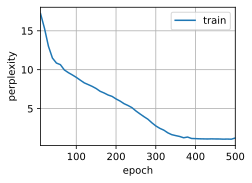

In [6]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_params, init_gru_state, gru)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

# GRU简洁实现

perplexity 1.0, 98463.0 tokens/sec on cuda:0
time traveller with a slight accession ofcheerfulness really thi
traveller with a slight accession ofcheerfulness really thi


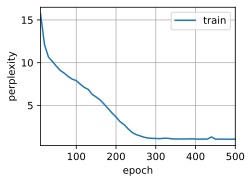

In [7]:
num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, num_hiddens)
model = d2l.RNNModel(gru_layer, len(vocab))
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

# GUR和LSTM的对比

GRU（Gated Recurrent Unit）和LSTM（Long Short-Term Memory）都是循环神经网络（RNN）中的变体，用于处理序列数据，并具有对长期依赖建模的能力。

尽管GRU和LSTM都是为了解决RNN中的梯度消失和梯度爆炸问题而提出的，它们在网络结构和门控机制上有所不同：

1. LSTM（Long Short-Term Memory）：LSTM引入了输入门、遗忘门和输出门来控制信息的流动。输入门和遗忘门决定了是否更新和遗忘信息，输出门则控制着哪些信息被输出到下一个时间步。LSTM使用一个记忆单元（cell state）来存储和传递信息，它能够长时间地保持和传递状态。

2. GRU（Gated Recurrent Unit）：GRU是LSTM的一种简化版本，它合并了输入门和遗忘门为一个更新门，同时将记忆单元和隐藏状态合并为一个隐藏状态。GRU通过重置门来控制上一个时间步的隐藏状态对当前时间步的影响，通过更新门来控制上一个时间步的隐藏状态和候选隐藏状态的融合程度。

虽然GRU和LSTM在网络结构上有所不同，但它们的目标是相同的：解决长序列数据中的梯度问题，并能够更好地捕捉时间序列中的长期依赖关系。在实践中，选择使用GRU还是LSTM取决于具体的任务和数据集。有时候GRU表现良好且计算效率高，而在其他情况下LSTM可能更适合处理复杂的时间序列模式。